## Distribución del clasificador RF

El objetivo de este notebook es el de jugar con los nuevos datos de protones y gammas, optimizar los hiperparámetros y finalmente, obtener la distribución del clasificador (lo que hemos hecho hasta ahora pero con más datos y entender al 100% el clasificador RF). 

### 1. Determinación del mejor RF posible

La diferencia principal con los códigos anteriores es que el número de datos con el que se entrena el modelo crece considerablemente, además de que quitamos las restricciones de los datos para trabajar con datos de MonteCarlo puros. Ahora se trabaja con aproximadamente 10 veces más de sucesos (40.000-50.000).

#### Código para importar módulos y leer los datos (todo hasta justo antes de entrenarlo)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Distribución del clasificador
import scipy.stats as stats

# Cargamos imágenes
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=100000)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=100000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()                                                             
print(df_protons.shape)
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
print(df_gamma.shape)

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(47355):
    label.append(1)                                                                   # Nombramos los protones como 1
for j in range(55449):
    label.append(0)                                                                   # Nombramos los gamma como 0
    
df_protongamma.insert(6,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]

print(df_protongamma[47350:47360])

(47355, 6)
(55449, 6)
       hillas_intensity  hillas_skewness  hillas_kurtosis  hillas_length  \
62367         70.205965         0.316879         1.694380       0.070671   
62368         80.952032         0.092583         1.765317       0.067121   
62369        132.952825         0.055950         2.198049       0.071503   
62370        153.501084         0.039215         1.907333       0.168361   
62371         61.250402        -0.101237         1.581294       0.071639   
0            479.200888        -0.143971         1.398851       0.565622   
4            262.133042        -0.036407         1.559445       0.552605   
5            220.744470         0.205672         1.736483       0.382769   
6            191.567611         0.188583         1.596721       0.375030   
7            121.020280         0.089623         1.476022       0.190436   

       hillas_width  timing_slope  label  
62367      0.056003      1.309635      1  
62368      0.044492     -1.974835      1  
62369      0

Ya tenemos los datos preparados para entrenar el modelo:

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

Realizamos una primera evaluación para ver cómo ha mejorado el modelo con una mayor estadística así como del peso de los parámtros que el modelo considera a la hora de tomar la decisión:

0.7039414808762305


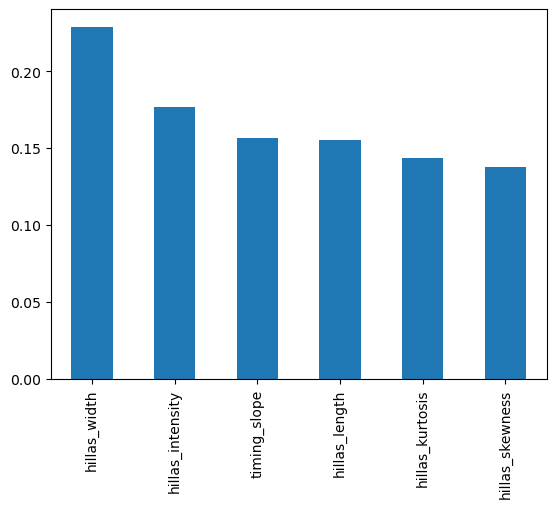

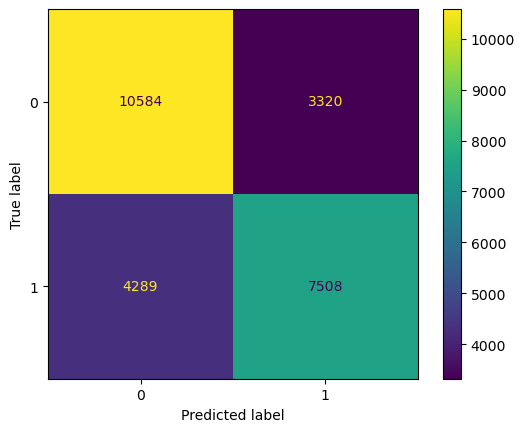

In [7]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

Está claro que el modelo ha mejorado considerablemente, y eso que solo hemos hecho una primera aproximación.

### 1.1 Mejora de los hiperparámetros

Al igual que en los casos previos vamos a ver para qué número de estimadores y para cuántas decisiones el modelo proporciona mejores resultados y ver si podemos obtener algún resultado concluyente:

In [9]:
nest = []
maxdep = []
accur = []

n0_estimators = 50
for i in range(10):
    max0_depth = 3
    for j in range(15):
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        nest.append(n0_estimators)
        maxdep.append(max0_depth)
        accur.append(accuracy)
        max0_depth = max0_depth + 2
        print(accuracy)
    n0_estimators = n0_estimators + 25
    print()

0.6374849227656512
0.6676783004552352
0.6829695342593674
0.6976771331854792
0.708649468892261
0.710594918485662
0.7089607408272052
0.7118400062254387
0.71043928251819
0.710556009493794
0.7075989261118244
0.704953114664799
0.7047196607135909
0.7035912999494183
0.7031243920470021

0.6347223843430216
0.6677561184389712
0.6820357184545348
0.6970934983074588
0.7063927473639158
0.7113341893311544
0.7121512781603828
0.7106727364693981
0.7101669195751138
0.7085716509085249
0.7094276487296214
0.7078712890549006
0.704953114664799
0.7054589315590833
0.7050698416404031

0.6395081903427882
0.6619586786506362
0.6817244465195906
0.695420411657134
0.7054200225672153
0.7118400062254387
0.7133185479164235
0.7118400062254387
0.7114898252986265
0.708610559900393
0.7116843702579666
0.7076378351036925
0.7072098361931443
0.7049142056729311
0.7043305707949107

0.6402863701801487
0.6624644955449205
0.6829306252674994
0.6938640519824132
0.7074043811524844
0.7113730983230224
0.7125014590871951
0.712306914127855


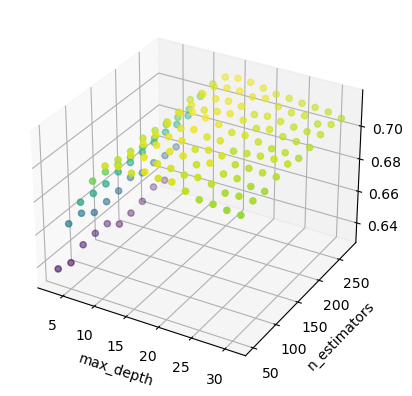

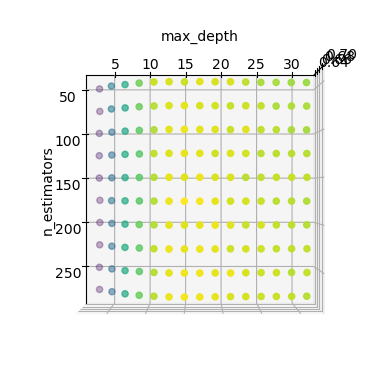

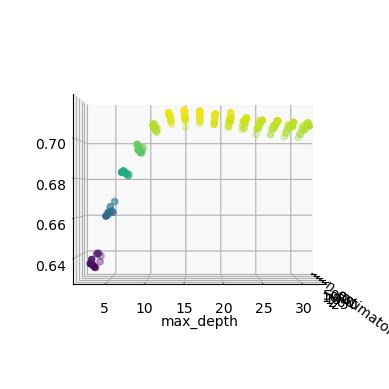

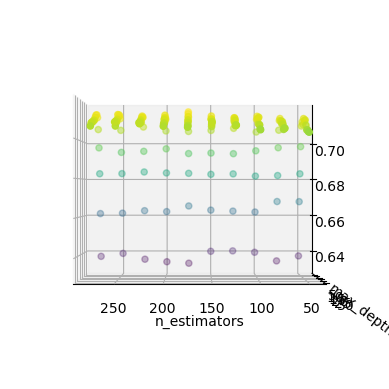

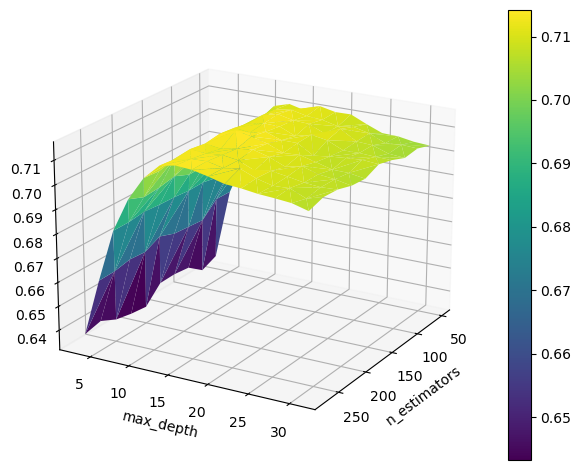

In [14]:
# Representamos los resultados para ver gráficamente la precisión del modelo

ax = plt.axes(projection='3d') 
ax.scatter(maxdep, nest, accur, c=accur, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nest, maxdep, accur, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(20, 30)
plt.show()

Está claro que el máximo se obtiene en max_depth = 13-17 siendo bastante independiente del número de estimadores, donde no hay ninguna tendencia clara, manteniéndose más o menos constante. Aún así, vamos a intentar afinar el hiperparámetro n_estimators a ver si obtenemos algún resultado concluyente:

In [16]:
nest2 = []
accur2 = []

n0_estimators = 60
for i in range(20):
    # RF1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = 15)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy1 = accuracy_score(y_test, y_pred)

    # RF2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = 15)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy2 = accuracy_score(y_test, y_pred)

    # RF3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = 15)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy3 = accuracy_score(y_test, y_pred)

    # RF4
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = 15)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy4 = accuracy_score(y_test, y_pred)

    accuracymean = (accuracy1 + accuracy2 + accuracy3 + accuracy4)/4
    
    nest2.append(n0_estimators)
    accur2.append(accuracymean)
    
    print(accuracymean)
    n0_estimators = n0_estimators + 20

0.7100112836076417
0.7101863740710479
0.7111882806116494
0.7117719154896697
0.710497646005992
0.7121901871522509
0.7119664604490097
0.71235555036769
0.7100599198474767
0.7118886424652737
0.712472277343294
0.710273919302751
0.7080171977744055
0.710478191510058
0.7121512781603828
0.7128030037741722
0.7088342866036341
0.7099723746157738
0.7128613672619742
0.7116746430099996


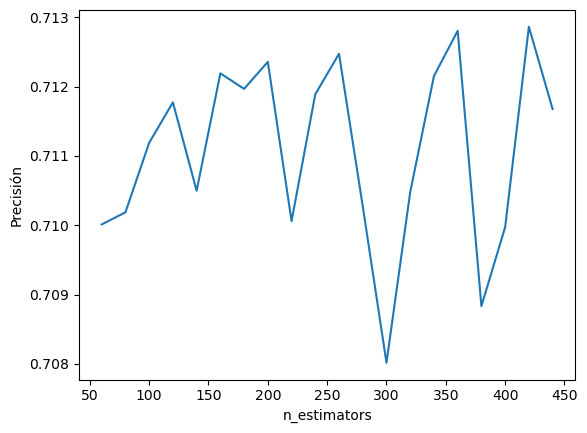

In [20]:
plt.plot(nest2,accur2)
plt.xlabel("n_estimators")
plt.ylabel("Precisión")
plt.show()

Como se puede ver, no hay minguna tendencia concreta para el cual mejora la precisión del modelo (y eso que se ha aumentado la robustez de los resultados mediante el cómputo de la media de los resultados de 4 RF independientes). Quizás es levemnte lineal pero el restultado de 150-200 estimadores es más que suficiente para nuestro objetivo. De cualquier forma, los hiperparámetros que optimizan los resultados del RF son max_depth = 15 y n_estimators = 150-200.

### 2. Umbral, curva ROC y matriz de confusión

Ahora antes de hacer la distribución del clasificador calculamos los procesos del notebook anterior: la matriz de confusión para distintos umbrales y la curva ROC del clasificador a ver si con una mayor cantidad de sucesos los resultados mejoran considerablemente.

In [3]:
# Entrenamos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier(n_estimators = 170, max_depth = 15)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=170)

Ahora ya está entrenado el modelo del RF, estudiamos los resultados del mismo a partir de los parámetros que hemos analizado:

In [15]:
thresholds = np.arange(0, 1.01, 0.01)

# Creamos los arrays que van a representar nuestros valores:
TP = []
FN = []
FP = []
TN = []
total = []
TPRp=[]                                                                       # Para protones
FPRp=[]
TPRg=[]                                                                       # Para gammas
FPRg=[]
accuracy = []

for threshold in thresholds:
    y_pred = (rf_model.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    
    TPi=cm[1,1]
    FNi=cm[1,0]
    FPi=cm[0,1]
    TNi=cm[0,0]
    totali = TPi + TNi + FNi + FPi
    TPRpi=TPi/(TPi+FNi)
    FPRpi=FPi/(FPi+TNi)
    TPRgi=TNi/(TNi+FPi)
    FPRgi=FNi/(FNi+TPi)
    accuracyi = accuracy_score(y_test, y_pred)
    if abs(TPi-TNi) < 300:                                                       # Deveulve el umbral para cual se maximizan el número de TP Y TN
        print("Umbral que maximiza TP y TN:", threshold)
    elif abs(FPi-FNi) < 300:                                                     # Deveulve el umbral para cual se minimizan el número de FP Y FN
        print("Umbral que minimiza FP y FN:", threshold)
    elif abs(TPRpi-TPRgi) < 0.05:                                               # Deveulve el umbral para cual la curva ROC se tuerce
        print("Umbral mejor según ROC:", threshold)                         
    TP.append(TPi)
    FN.append(FNi)
    FP.append(FPi)
    TN.append(TNi)
    total.append(totali)
    TPRp.append(TPRpi)
    FPRp.append(FPRpi)
    TPRg.append(TPRgi)
    FPRg.append(FPRgi)
    accuracy.append(accuracyi)
print("Umbral que maximiza la precisión:", accuracy.index(max(accuracy))/100)

Umbral que maximiza TP y TN: 0.43
Umbral mejor según ROC: 0.45
Umbral mejor según ROC: 0.46
Umbral que maximiza la precisión: 0.49


Representamos TP, TN, FP y FN en función del umbral:

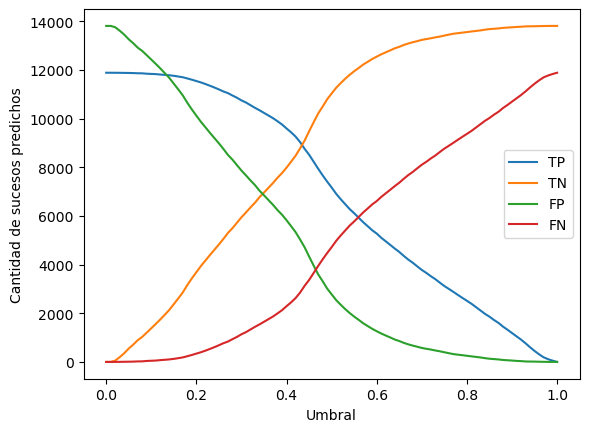

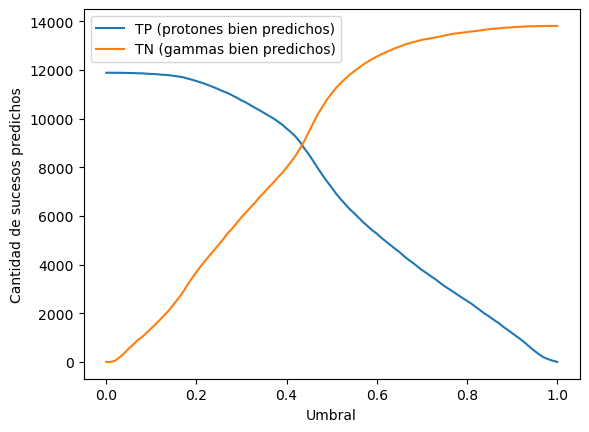

In [16]:
# Representamos los resultados para TP, FP, TN y FN
plt.plot(thresholds, TP, label = "TP")
plt.plot(thresholds, TN, label = "TN")
plt.plot(thresholds, FP, label = "FP")
plt.plot(thresholds, FN, label = "FN")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Distribución del clasificador RF
plt.plot(thresholds, TN, label = "TN (gammas bien predichos)")
plt.plot(thresholds, TP, label = "TP (protones bien predichos)")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

Representamos también la precisión del modelo en función del umbral escogido:

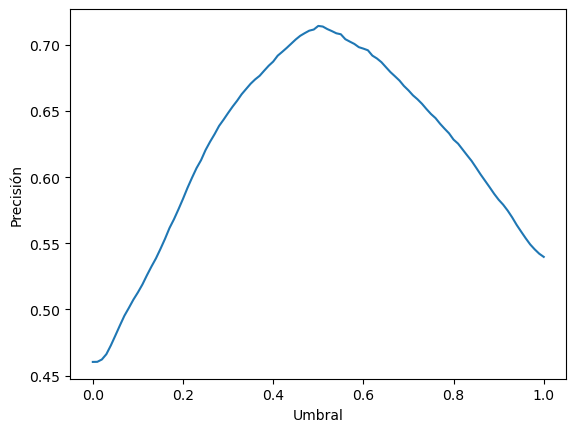

In [8]:
# Representamos la precisión
plt.plot(thresholds, accuracy)
plt.xlabel("Umbral")
plt.ylabel("Precisión")
plt.show()

Calculamos las "mejores" matrices de confusión, es decir, la que maximiza TP y TN y la que minimiza FP y FN:

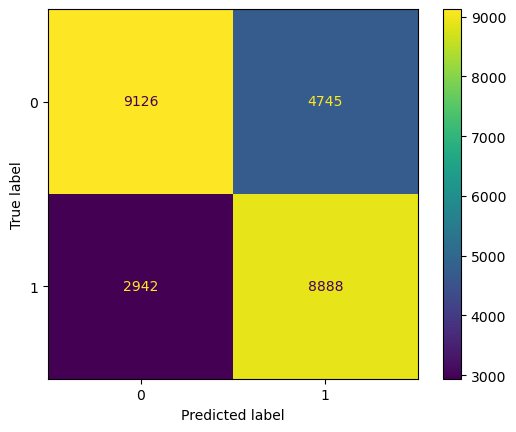

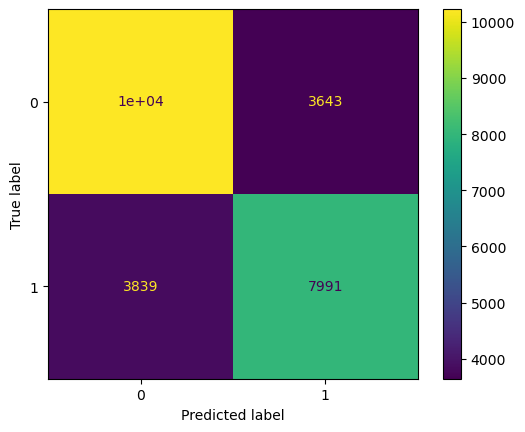

In [9]:
# Definimos el umbral que maximiza TP y TN y el que minimiza FP y FN:
thresholdmax = 0.44
thresholdmin = 0.47

# Comprobamos los resultados
y_pred = (rf_model.predict_proba(X_test)[:,1]>thresholdmax).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rf_model.predict_proba(X_test)[:,1]>thresholdmin).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

Finalmente, representamos la curva ROC (para protones y para gammas) y calculamos el AUC:

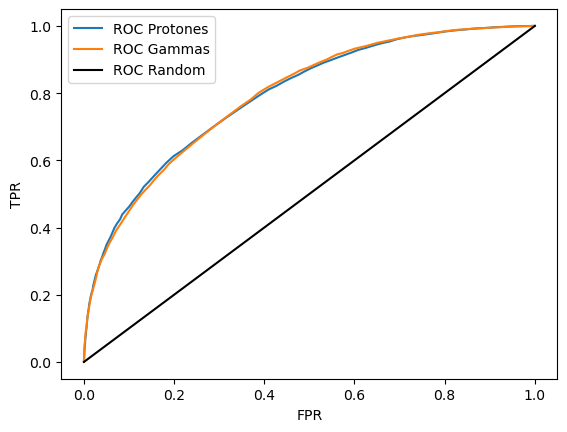

AUC para ROC de protones 0.7927368306676549
AUC para ROC de gammas 0.7927368306676549
AUC para ROC de random 0.5


In [12]:
from sklearn.metrics import RocCurveDisplay, auc

# Representamos la curva ROC (para protones y gammas)
plt.plot(FPRp, TPRp, label = "ROC Protones")
plt.plot(FPRg, TPRg, label = "ROC Gammas")
ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print('AUC para ROC de protones', auc(FPRp,TPRp))
print('AUC para ROC de gammas', auc(FPRg,TPRg))
print('AUC para ROC de random', 0.5)

Como se puede comprobar, los resultados han mejorado considerablemente, obteniéndose un AUC de 0.80. A partir de ahora trataremos de obtener la distribución del clasificador de los sucesos de comprobación.

### 3. Distribución del clasificador

Ahora que entendemos cómo de clasifica el RandomForest y cómo se evalúa procedemos al último paso para entender el modelo: reproducir una distribución de probabilidad del clasificador. En esencia, es un histograma que recoge todos los eventos con los que el modelo comprueba su entrenamiento y representa la frecuencia de resultados que obtiene. Si 0 es que el RF ha determinado que, para cierto evento, la partícula que lo inicia es un gamma y si 1 es que el RF determina que es un protón, cualquier número entre estos representa la pureza del resultado del RF, es decir, 0.2 indica que el 20% de los árboles determinan que es un protón y el 80% determina que es un gamma. Así es como se construye el histograma que representamos a continuación.

In [2]:
# Entrenamos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier(n_estimators = 170, max_depth = 15)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=170)

In [4]:
y_pred = (rf_model.predict_proba(X_test))
print(y_pred)

[[0.55011747 0.44988253]
 [0.57431052 0.42568948]
 [0.54776093 0.45223907]
 ...
 [0.47573658 0.52426342]
 [0.04950824 0.95049176]
 [0.34008928 0.65991072]]


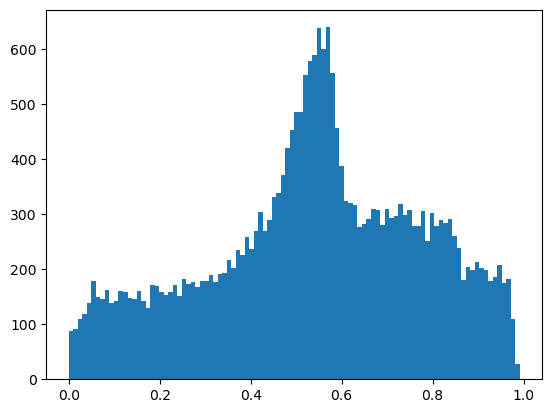

In [8]:
plt.hist(y_pred[:,0], bins=100)
plt.show()

Esta distribución no parece especialmente buena, vamos a calcularla para distintos hiperparámetros del modelo y ver cómo se comporta y si mejora algo los resultados ya que en esta distribución el grueso de los resultados caen en la franja del 0.5, es decir, que el modelo es bastante aleatorio. Lo óptimo sería que hubiera picos cerca de 0 y cerca de 1, indicando que el modelo distingue bastante bien los sucesos y que la gran mayoría de árboles están de acuerdo en la decisión y no se basa en el 50%.

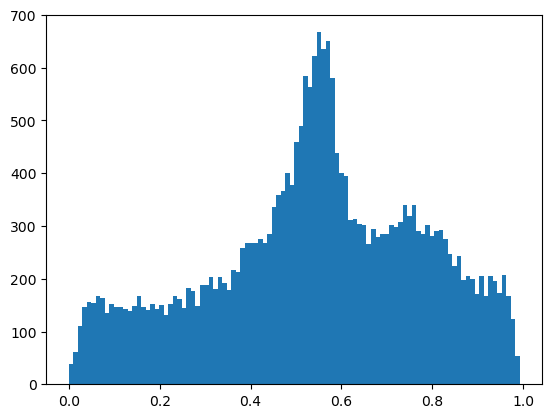

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)
rf_model.fit(X_train, y_train)
y_pred = (rf_model.predict_proba(X_test))
plt.hist(y_pred[:,0], bins=100)
plt.show()

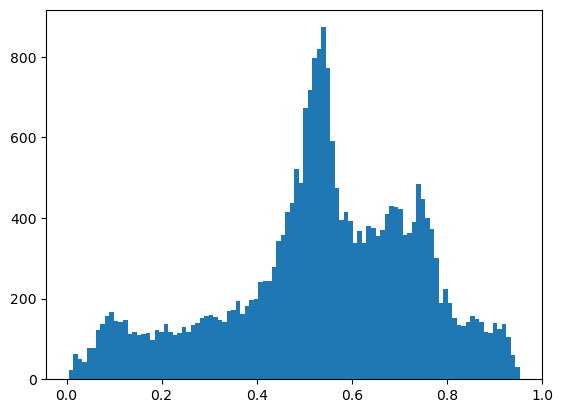

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf_model = RandomForestClassifier(n_estimators = 100, max_depth = 10)
rf_model.fit(X_train, y_train)
y_pred = (rf_model.predict_proba(X_test))
plt.hist(y_pred[:,0], bins=100)
plt.show()

Tras un estudio más en profundidad del comportamiento y del funcionamiento del RandomForest, se ha concluido que esta distribución es correcta y es difícil de mejorar. Una distribución con dos picos sería lo mejor y minizaría los FP y FN todo lo posible. Sigue siendo el objetivo, pero parece complicado de obtener. Pese a ello, voy a seguir intentándolo con más datos y quizás con algún otro hiperparámetro.

Ahora se muestra la distribución que nos devuelve el RF para varios hiperparámetros y su clasificación real de si eran protones o gammas.

#### Distribución para max_depth = 15 y n_estimators = 50 - 250

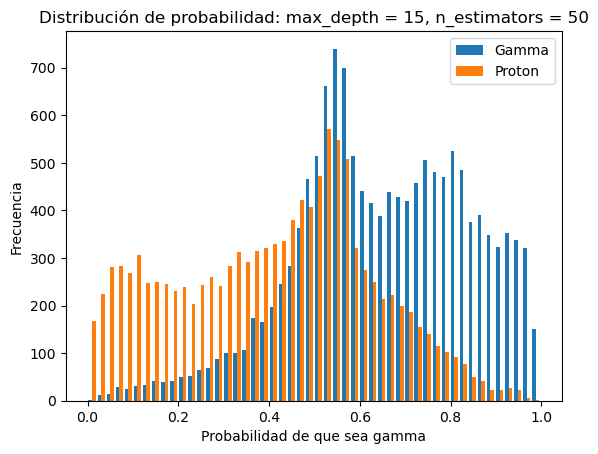

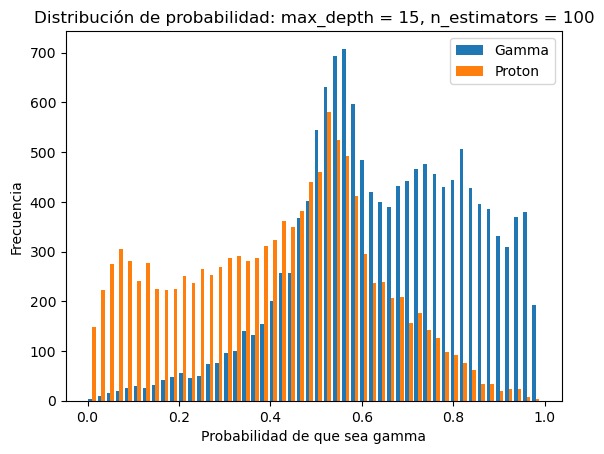

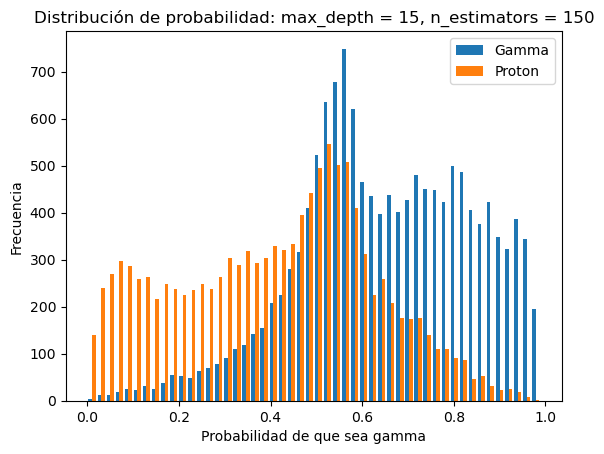

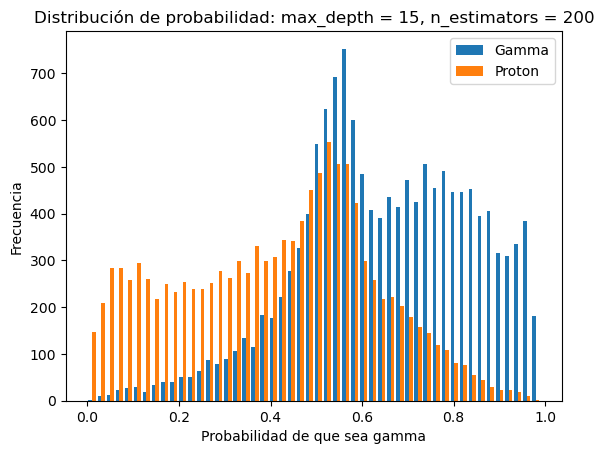

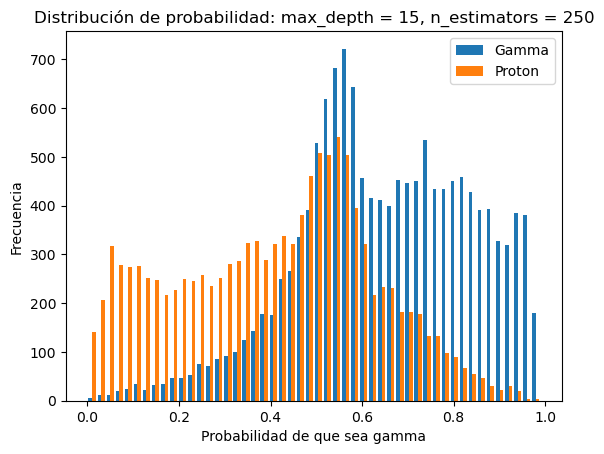

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
label = y_test                                                                                     # Etiquetas reales de los sucesos
n0_estimators = 50
max0_depth = 15
for i in range(5):
    rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
    rf.fit(X_train, y_train)
    y_pred = (rf.predict_proba(X_test))
    proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
    # Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
    prob_gamma = proba[label == 0]
    prob_proton = proba[label == 1]
    
    plt.hist([prob_gamma, prob_proton], bins=50, label=['Gamma', 'Proton'])

    plt.title('Distribución de probabilidad: max_depth = 15, n_estimators = %i'%n0_estimators)
    plt.xlabel("Probabilidad de que sea gamma")
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()

    n0_estimators = n0_estimators + 50

Vemos que no varía mucho la distribución según el número de árboles

#### Distribución sin tocar hiperparámetros

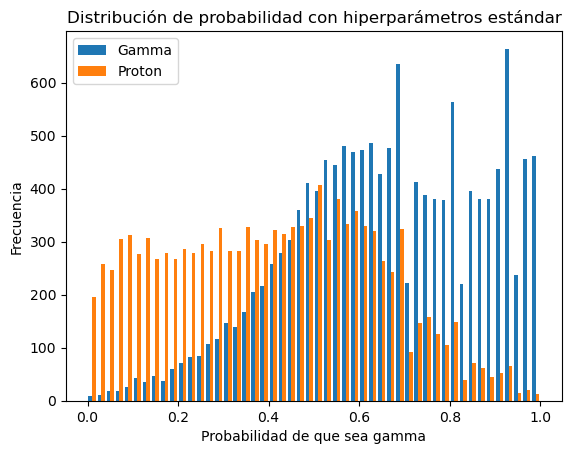

In [50]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]
    
plt.hist([prob_gamma, prob_proton], bins=50, label=['Gamma', 'Proton'])

plt.title("Distribución de probabilidad con hiperparámetros estándar")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

La gaussiana se aplana pero no queda claro si esta distribución es mejor que aquella con max_depth = 15

#### Distribución para max_depth = 15 y n_estimators = 150

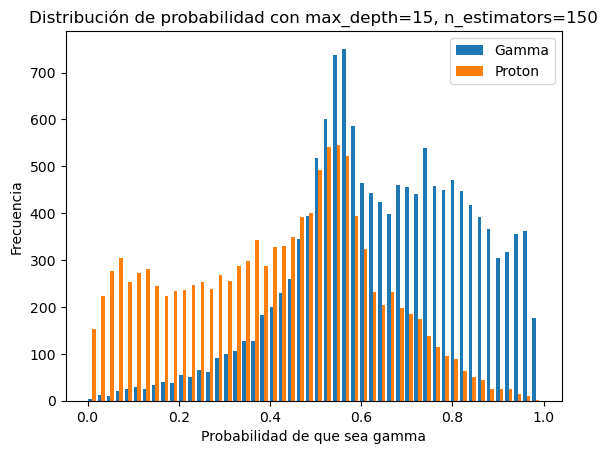

In [79]:
rf = RandomForestClassifier(max_depth=15, n_estimators=150)
rf.fit(X_train, y_train)
y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]
    
plt.hist([prob_gamma, prob_proton], bins=50, label=['Gamma', 'Proton'])

plt.title("Distribución de probabilidad con max_depth=15, n_estimators=150")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

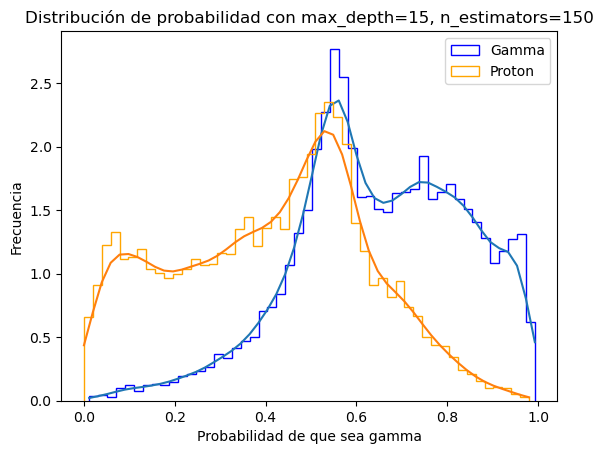

In [80]:
y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=15, n_estimators=150")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

#### Distribución para max_depth = 3 - 36 y n_estimators = 50 - 200

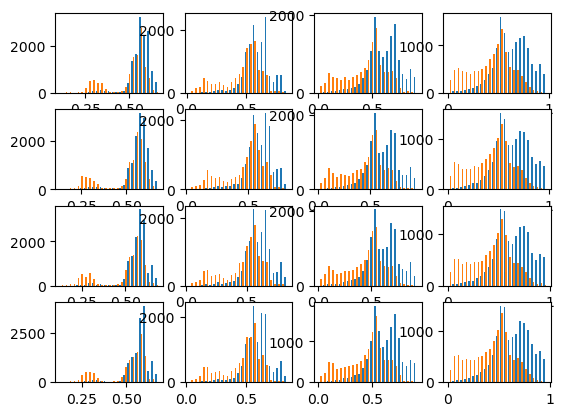

In [70]:
fig, axs = plt.subplots(4, 4)

n0_estimators = 50
for i in range(4):
    max0_depth = 3
    for j in range(4):
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = (rf.predict_proba(X_test))
        proba = y_pred[:,0] 

        # Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
        prob_gamma = proba[label == 0]
        prob_proton = proba[label == 1]
        
        axs[i,j].hist([prob_gamma, prob_proton], bins=25, label=['Gamma', 'Proton'])

        max0_depth = max0_depth + 3
    n0_estimators = n0_estimators + 50       

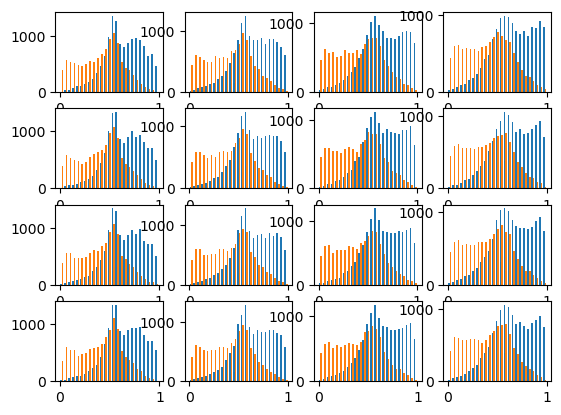

In [71]:
fig, axs = plt.subplots(4, 4)

n0_estimators = 50
for i in range(4):
    max0_depth = 15
    for j in range(4):
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = (rf.predict_proba(X_test))
        proba = y_pred[:,0] 

        # Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
        prob_gamma = proba[label == 0]
        prob_proton = proba[label == 1]
        
        axs[i,j].hist([prob_gamma, prob_proton], bins=25, label=['Gamma', 'Proton'])

        max0_depth = max0_depth + 3
    n0_estimators = n0_estimators + 50   

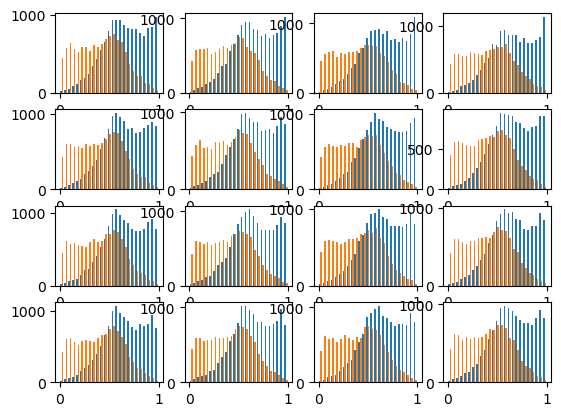

In [72]:
fig, axs = plt.subplots(4, 4)

n0_estimators = 50
for i in range(4):
    max0_depth = 27
    for j in range(4):
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = (rf.predict_proba(X_test))
        proba = y_pred[:,0] 

        # Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
        prob_gamma = proba[label == 0]
        prob_proton = proba[label == 1]
        
        axs[i,j].hist([prob_gamma, prob_proton], bins=25, label=['Gamma', 'Proton'])

        max0_depth = max0_depth + 3
    n0_estimators = n0_estimators + 50   

Vemos que a mayor cantidad de decisiones más se parece al RF sin modificar los hiperparámetros... pero ¿es este el mejor RF?

Vamos a intentar encontrar el mejor posible con lo que tenemos

## 4. Mejorando la distribución

Es difícil optimizar todo esto porque los mejores resultados pueden ser:

1. Maximizan TP y TN
2. Minimizan FP y FN
3. Maximizan precisión
4. Maximizan ROC y AUC
   
Probablemente estén relacionados entre sí. Vamos a intentar encontrar el threshold que mejora estos parámetros (o la mayoría de estos).
Además, como hemos estado viendo el hiperparámetro de n_estimators no afecta prácticamente a los resultados que estamos obteniendo, usaremos 125 por defecto y si eso intentaremos optimizar max_depth.

Vamos a empezar desde cero cargando unos cuantos más datos a ver cómo es el RF con datos totalmente nuevos.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Distribución del clasificador
import scipy.stats as stats

# Cargamos imágenes
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=100000, stop=250000)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=100000, stop=250000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
print(df_protons.shape)

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]
print(df_gamma.shape)

(38873, 6)
(46193, 6)


In [7]:
# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
    
df_protongamma.insert(6,"label", label, True)                                         # Inserta la etiqueta real en el dataframe

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Entrenamos el modelo:

In [8]:
rfh = RandomForestClassifier(max_depth=15, n_estimators=125)
rfh.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=125)

In [7]:
rfs = RandomForestClassifier()
rfs.fit(X_train, y_train)

RandomForestClassifier()

Mostramos los resultados de la distribución que nos devuelve el RandomForest, tanto el estándar como para el de mejor hiperparámetros:

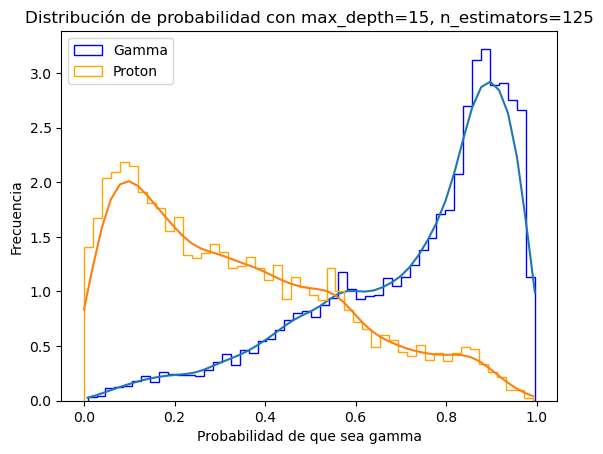

In [9]:
y_predh = (rfh.predict_proba(X_test))
probah = y_predh[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
labelh = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gammah = probah[labelh == 0]
prob_protonh = probah[labelh == 1]

densitygh = stats.gaussian_kde(prob_gammah)
ngh, xgh, _ = plt.hist(prob_gammah, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xgh, densitygh(xgh))

densityph = stats.gaussian_kde(prob_protonh)
nph, xph, _ = plt.hist(prob_protonh, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xph, densityph(xph))

plt.title("Distribución de probabilidad con max_depth=15, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

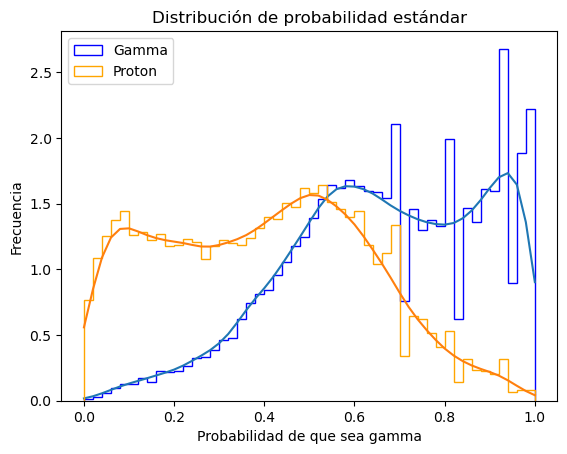

In [16]:
y_preds = (rfs.predict_proba(X_test))
probas = y_preds[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
labels = y_test                                                                                  # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gammas = probas[labels == 0]
prob_protons = probas[labels == 1]

densitygs = stats.gaussian_kde(prob_gammas)
ngs, xgs, _ = plt.hist(prob_gammas, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xgs, densitygs(xgs))

densityps = stats.gaussian_kde(prob_protons)
nps, xps, _ = plt.hist(prob_protons, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xps, densityps(xps))

plt.title("Distribución de probabilidad estándar")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

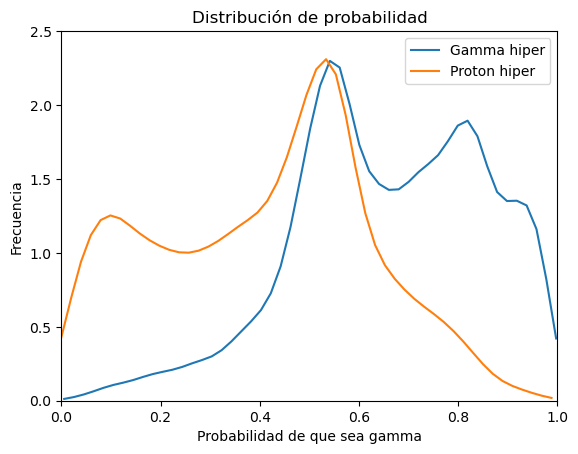

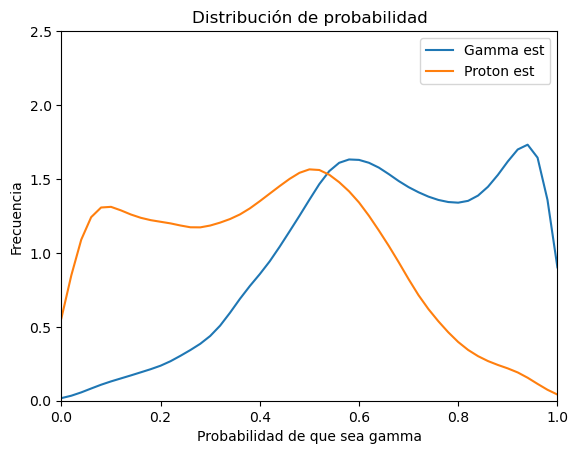

In [21]:
plt.plot(xgh, densitygh(xgh), label="Gamma hiper")
plt.plot(xph, densityph(xph), label="Proton hiper")
plt.title("Distribución de probabilidad")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
plt.legend()
plt.show()

plt.plot(xgs, densitygs(xgs), label="Gamma est")
plt.plot(xps, densityps(xps), label="Proton est")
plt.title("Distribución de probabilidad")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
plt.legend()
plt.show()

Una vez hemos obtenido estas distribuciones, solo falta determinar el punto del threshold a partir del cual vamos a determinar que la probabilidad de protón o gamma lo llamaremos realmente protón o gamma. Es decir, si determinamos el threshold como 0.8, las probabilidades determinadas por el RF por encima de 0.8 los llamaremos gamma y todo lo que esté por debajo lo llamaremos protón. En vista de la distribución, tendremos muchos gammas bien predichos, pues a 0.8 tenemos muchos gammas y muy pocos protones pero obtendremos también muchos falsos protones ya que todo el gruso de gammas del 0.6 hacia abajo serán nombrados como protones. La gracia aquí es para qué valor del threshold encontraremos los mejores resultados.

Vamos todo el rato a compararlos con el RF estándar para ver si los hiperparámetros sirven realmente de algo.

In [11]:
thresholds = np.arange(0, 1.01, 0.01)

# Creamos los arrays que van a representar nuestros valores:
TP = []
FN = []
FP = []
TN = []
total = []
TPRp=[]                                                                       # Para protones
FPRp=[]
TPRg=[]                                                                       # Para gammas
FPRg=[]
accuracy = []

for threshold in thresholds:
    y_pred = (rfh.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    
    TPi=cm[1,1]
    FNi=cm[1,0]
    FPi=cm[0,1]
    TNi=cm[0,0]
    totali = TPi + TNi + FNi + FPi
    TPRpi=TPi/(TPi+FNi)
    FPRpi=FPi/(FPi+TNi)
    TPRgi=TNi/(TNi+FPi)
    FPRgi=FNi/(FNi+TPi)
    accuracyi = accuracy_score(y_test, y_pred)
    if abs(TPi-TNi) < 800:                                                       # Deveulve el umbral para cual se maximizan el número de TP Y TN
        print("Umbral que maximiza TP y TN:", threshold)
    elif abs(FPi-FNi) < 800:                                                     # Deveulve el umbral para cual se minimizan el número de FP Y FN
        print("Umbral que minimiza FP y FN:", threshold)
    elif abs(TPRpi-TPRgi) < 0.05:                                               # Deveulve el umbral para cual la curva ROC se tuerce
        print("Umbral mejor según ROC:", threshold)                         
    TP.append(TPi)
    FN.append(FNi)
    FP.append(FPi)
    TN.append(TNi)
    total.append(totali)
    TPRp.append(TPRpi)
    FPRp.append(FPRpi)
    TPRg.append(TPRgi)
    FPRg.append(FPRgi)
    accuracy.append(accuracyi)
print("Umbral que maximiza la precisión:", accuracy.index(max(accuracy))/100)

Umbral que maximiza TP y TN: 0.34
Umbral que maximiza TP y TN: 0.35000000000000003
Umbral que maximiza TP y TN: 0.36
Umbral que maximiza TP y TN: 0.37
Umbral que maximiza TP y TN: 0.38
Umbral que maximiza TP y TN: 0.39
Umbral que maximiza TP y TN: 0.4
Umbral que maximiza TP y TN: 0.41000000000000003
Umbral que maximiza TP y TN: 0.42
Umbral que minimiza FP y FN: 0.44
Umbral que minimiza FP y FN: 0.45
Umbral que minimiza FP y FN: 0.46
Umbral que minimiza FP y FN: 0.47000000000000003
Umbral que minimiza FP y FN: 0.48
Umbral que minimiza FP y FN: 0.49
Umbral que minimiza FP y FN: 0.5
Umbral que minimiza FP y FN: 0.51
Umbral que maximiza la precisión: 0.45


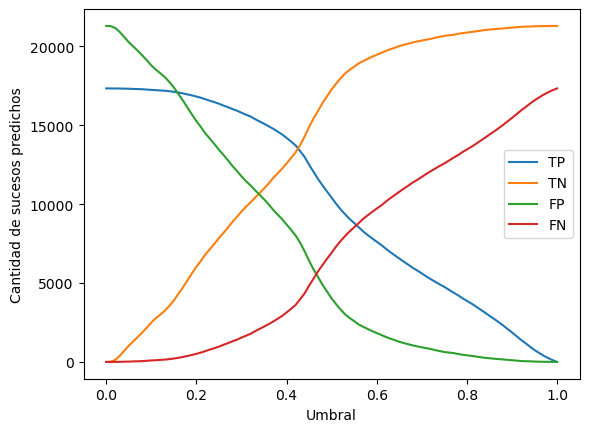

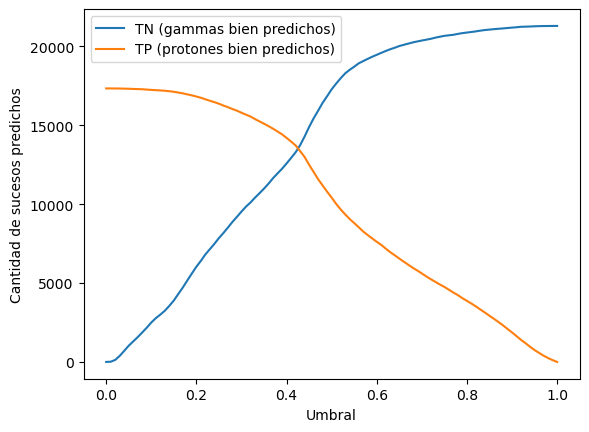

In [69]:
# Representamos los resultados para TP, FP, TN y FN
plt.plot(thresholds, TP, label = "TP")
plt.plot(thresholds, TN, label = "TN")
plt.plot(thresholds, FP, label = "FP")
plt.plot(thresholds, FN, label = "FN")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Distribución del clasificador RF
plt.plot(thresholds, TN, label = "TN (gammas bien predichos)")
plt.plot(thresholds, TP, label = "TP (protones bien predichos)")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

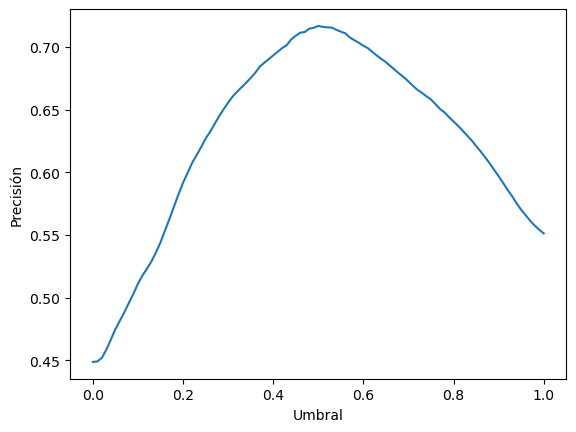

In [70]:
# Representamos la precisión
plt.plot(thresholds, accuracy)
plt.xlabel("Umbral")
plt.ylabel("Precisión")
plt.show()

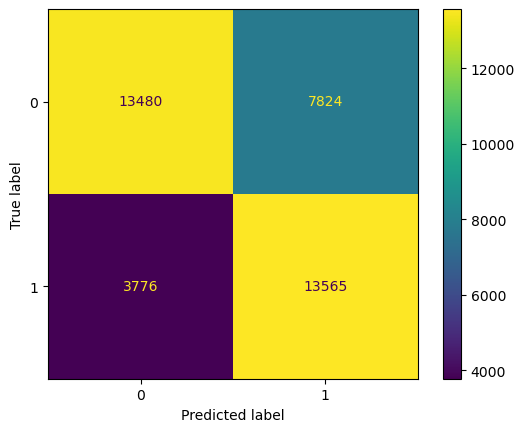

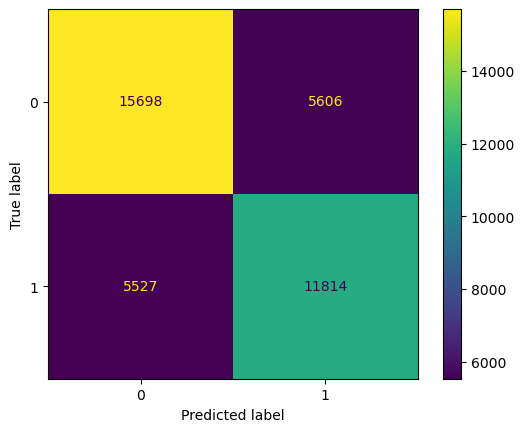

In [72]:
# Definimos el umbral que maximiza TP y TN y el que minimiza FP y FN:
thresholdmax = 0.425
thresholdmin = 0.465

# Comprobamos los resultados
y_pred = (rfh.predict_proba(X_test)[:,1]>thresholdmax).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfh.predict_proba(X_test)[:,1]>thresholdmin).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

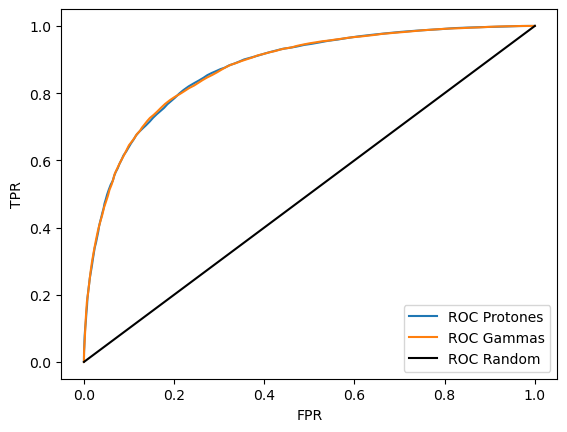

AUC para ROC de protones 0.8741443928049673
AUC para ROC de gammas 0.8741443928049673
AUC para ROC de random 0.5


In [12]:
from sklearn.metrics import RocCurveDisplay, auc

# Representamos la curva ROC (para protones y gammas)
plt.plot(FPRp, TPRp, label = "ROC Protones")
plt.plot(FPRg, TPRg, label = "ROC Gammas")
ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print('AUC para ROC de protones', auc(FPRp,TPRp))
print('AUC para ROC de gammas', auc(FPRg,TPRg))
print('AUC para ROC de random', 0.5)

Hacemos lo mismo para el RF sin optimizar los hiperparámetros

In [75]:
thresholds = np.arange(0, 1.01, 0.01)

# Creamos los arrays que van a representar nuestros valores:
TP = []
FN = []
FP = []
TN = []
total = []
TPRp=[]                                                                       # Para protones
FPRp=[]
TPRg=[]                                                                       # Para gammas
FPRg=[]
accuracy = []

for threshold in thresholds:
    y_pred = (rfs.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    
    TPi=cm[1,1]
    FNi=cm[1,0]
    FPi=cm[0,1]
    TNi=cm[0,0]
    totali = TPi + TNi + FNi + FPi
    TPRpi=TPi/(TPi+FNi)
    FPRpi=FPi/(FPi+TNi)
    TPRgi=TNi/(TNi+FPi)
    FPRgi=FNi/(FNi+TPi)
    accuracyi = accuracy_score(y_test, y_pred)
    if abs(TPi-TNi) < 800:                                                       # Deveulve el umbral para cual se maximizan el número de TP Y TN
        print("Umbral que maximiza TP y TN:", threshold)
    elif abs(FPi-FNi) < 800:                                                     # Deveulve el umbral para cual se minimizan el número de FP Y FN
        print("Umbral que minimiza FP y FN:", threshold)
    elif abs(TPRpi-TPRgi) < 0.05:                                               # Deveulve el umbral para cual la curva ROC se tuerce
        print("Umbral mejor según ROC:", threshold)                         
    TP.append(TPi)
    FN.append(FNi)
    FP.append(FPi)
    TN.append(TNi)
    total.append(totali)
    TPRp.append(TPRpi)
    FPRp.append(FPRpi)
    TPRg.append(TPRgi)
    FPRg.append(FPRgi)
    accuracy.append(accuracyi)
print("Umbral que maximiza la precisión:", accuracy.index(max(accuracy))/100)

Umbral que maximiza TP y TN: 0.4
Umbral que maximiza TP y TN: 0.41000000000000003
Umbral mejor según ROC: 0.44
Umbral mejor según ROC: 0.45
Umbral que minimiza FP y FN: 0.46
Umbral que minimiza FP y FN: 0.47000000000000003
Umbral que minimiza FP y FN: 0.48
Umbral que maximiza la precisión: 0.5


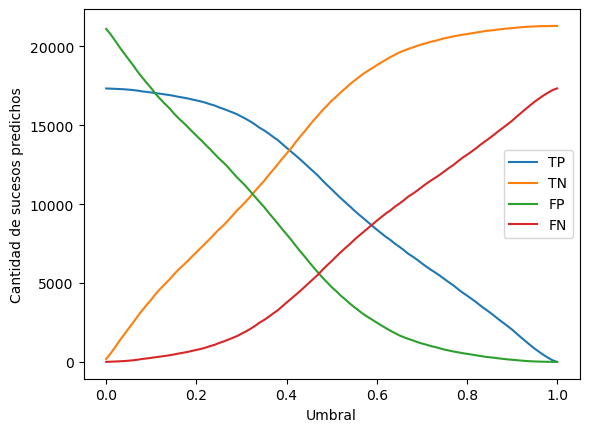

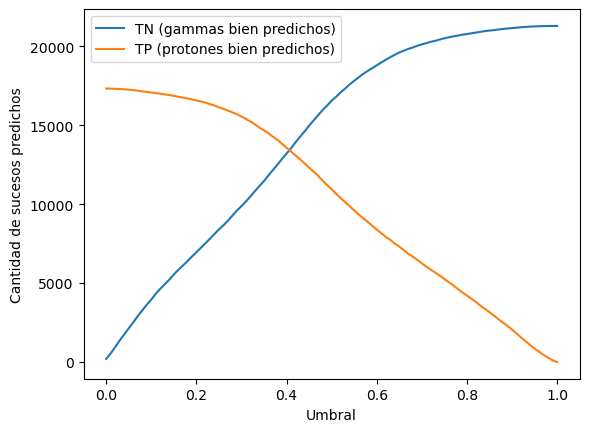

In [76]:
# Representamos los resultados para TP, FP, TN y FN
plt.plot(thresholds, TP, label = "TP")
plt.plot(thresholds, TN, label = "TN")
plt.plot(thresholds, FP, label = "FP")
plt.plot(thresholds, FN, label = "FN")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Distribución del clasificador RF
plt.plot(thresholds, TN, label = "TN (gammas bien predichos)")
plt.plot(thresholds, TP, label = "TP (protones bien predichos)")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

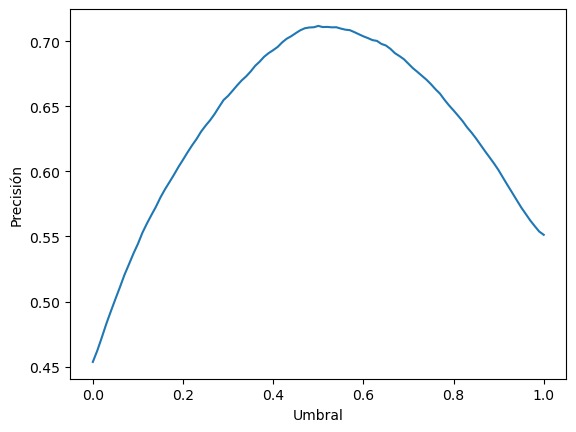

In [77]:
# Representamos la precisión
plt.plot(thresholds, accuracy)
plt.xlabel("Umbral")
plt.ylabel("Precisión")
plt.show()

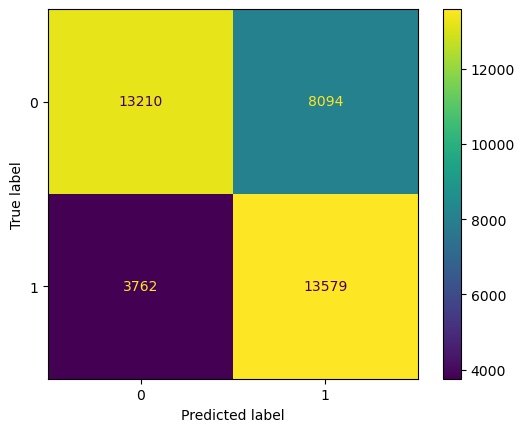

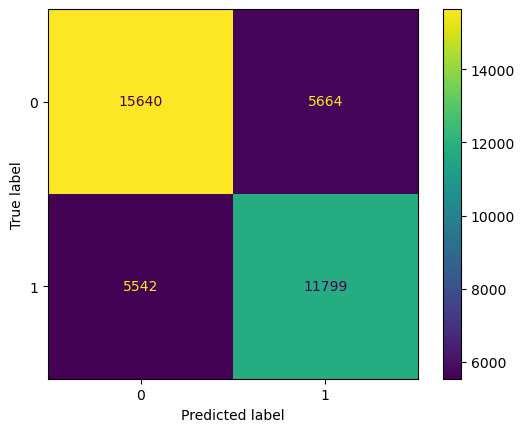

In [78]:
# Definimos el umbral que maximiza TP y TN y el que minimiza FP y FN:
thresholdmax = 0.405
thresholdmin = 0.47

# Comprobamos los resultados
y_pred = (rfs.predict_proba(X_test)[:,1]>thresholdmax).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfs.predict_proba(X_test)[:,1]>thresholdmin).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

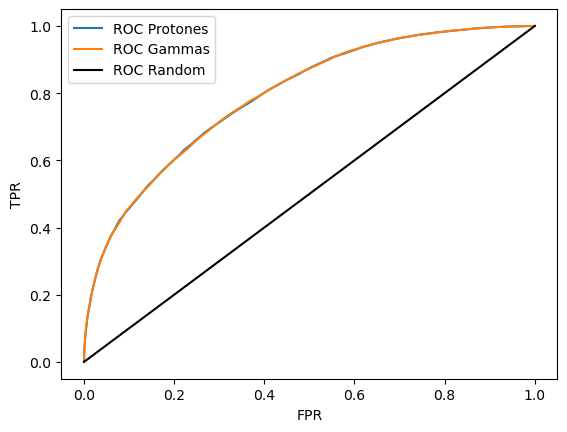

AUC para ROC de protones 0.7833370806107172
AUC para ROC de gammas 0.7923004650720327
AUC para ROC de random 0.5


In [79]:
from sklearn.metrics import RocCurveDisplay, auc

# Representamos la curva ROC (para protones y gammas)
plt.plot(FPRp, TPRp, label = "ROC Protones")
plt.plot(FPRg, TPRg, label = "ROC Gammas")
ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print('AUC para ROC de protones', auc(FPRp,TPRp))
print('AUC para ROC de gammas', auc(FPRg,TPRg))
print('AUC para ROC de random', 0.5)

Se puede ver que los resultados obtenidos a partir del RF con los hiperparámetros modificados es mejor que el RF estándar, aunque levemente, se mejoran los resultados.

### Por último, vamos a mostrar la distribución para diferentes RF según su max_depth

#### RF max_depth = 5

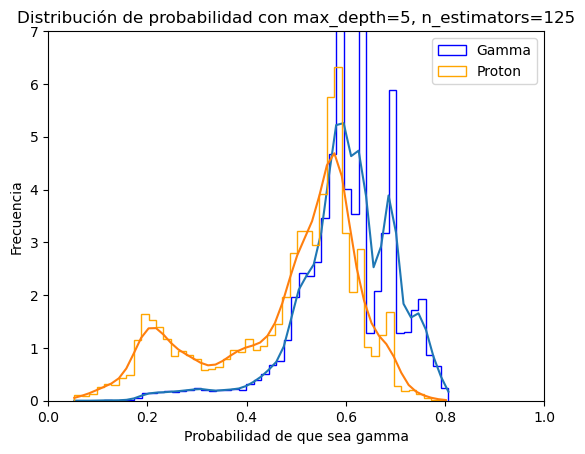

In [90]:
rf = RandomForestClassifier(max_depth=5, n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=5, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 7])
plt.legend()
plt.show()

#### RF max_depth = 10

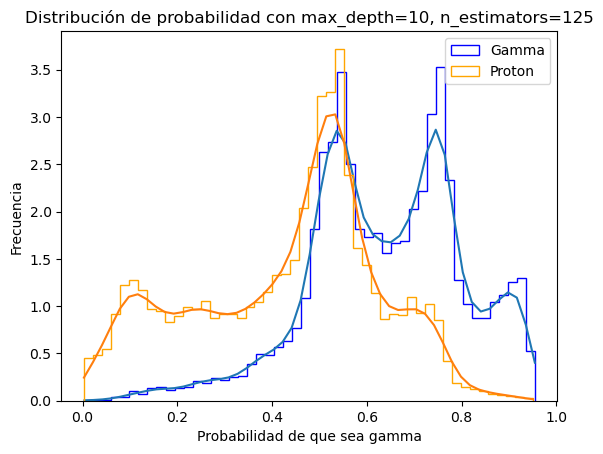

In [91]:
rf = RandomForestClassifier(max_depth=10, n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=10, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax.set_xlim([0, 1])
ax.set_ylim([0, 7])
plt.legend()
plt.show()

#### RF max_depth = 15

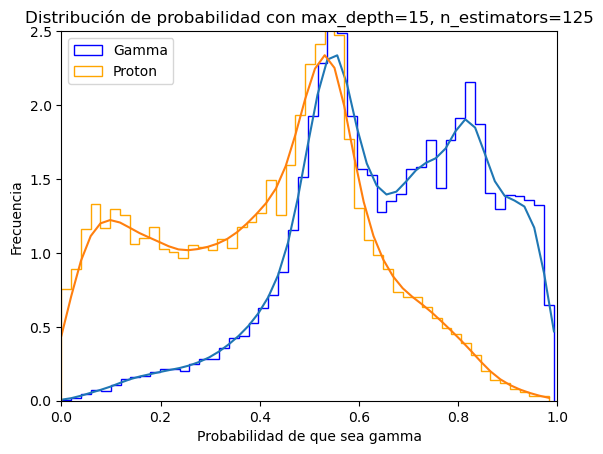

In [92]:
rf = RandomForestClassifier(max_depth=15, n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=15, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
plt.legend()
plt.show()

#### RF max_depth = 20

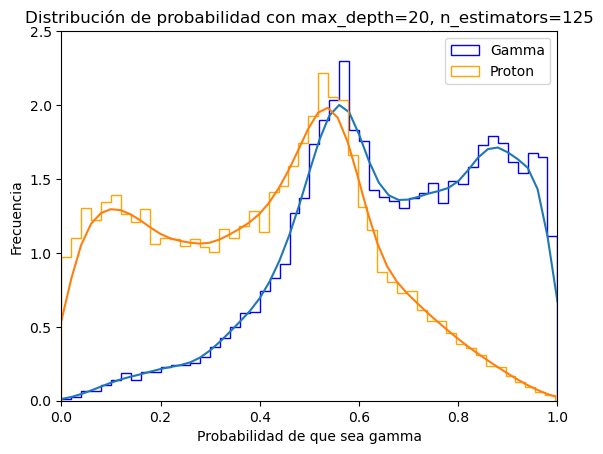

In [93]:
rf = RandomForestClassifier(max_depth=20, n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=20, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
plt.legend()
plt.show()

#### RF max_depth = 25

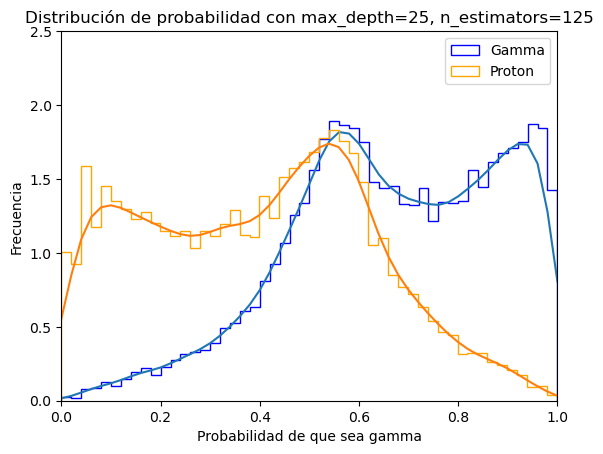

In [94]:
rf = RandomForestClassifier(max_depth=25, n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=25, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
plt.legend()
plt.show()

#### RF max_depth = 30

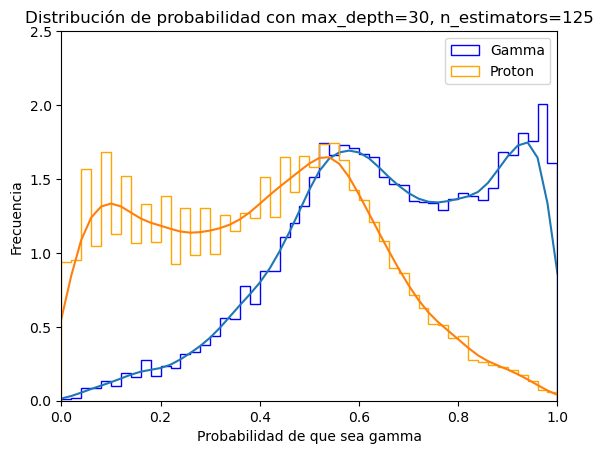

In [95]:
rf = RandomForestClassifier(max_depth=30, n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=30, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
plt.legend()
plt.show()

#### RF max_depth = 35

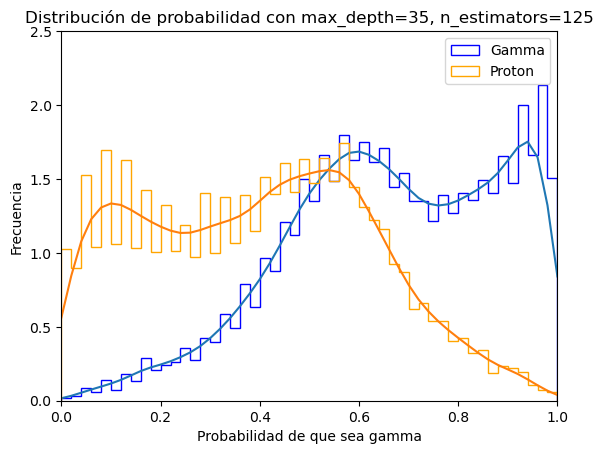

In [96]:
rf = RandomForestClassifier(max_depth=35, n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con max_depth=35, n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
plt.legend()
plt.show()

#### RF sin max_depth

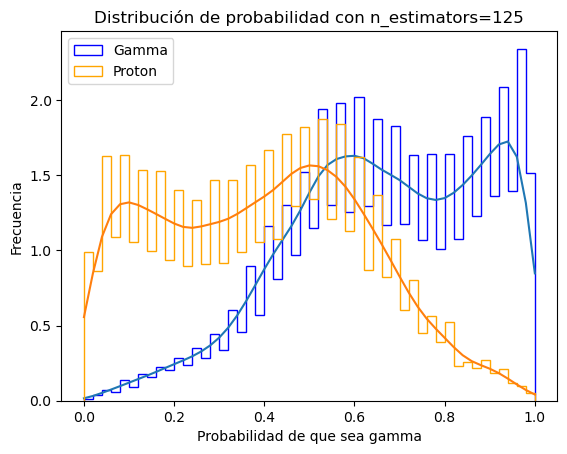

In [97]:
rf = RandomForestClassifier(n_estimators=125)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityp = stats.gaussian_kde(prob_proton)
np, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityp(xp))

plt.title("Distribución de probabilidad con n_estimators=125")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()